# Bitcoin Time Series Visualization and Anomaly Detection

In this notebook, we analyze Bitcoin price data collected in real time using Azure Event Hub and Blob Storage.  
We visualize key trends using rolling averages, rate of change, and z-scores to identify anomalies.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


### Load and Preprocess Data

In [2]:
# Loading the merged CSV (previously generated from JSON files)
df = pd.read_csv("json_files/merged_bitcoin_data.csv")  # adjust path if needed

# Converting timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Sorting by timestamp
df = df.sort_values('timestamp').reset_index(drop=True)

# Preview the dataset
df.head()


,currency,price_usd,timestamp
0,BTC,96503.0,2025-05-03 04:32:00.325596809
1,BTC,96503.0,2025-05-03 04:33:01.955163956
2,BTC,96500.0,2025-05-03 04:34:02.371683359
3,BTC,96498.0,2025-05-03 04:35:02.707802057
4,BTC,96497.0,2025-05-03 04:36:03.085242510


### 5-Point Rolling Average

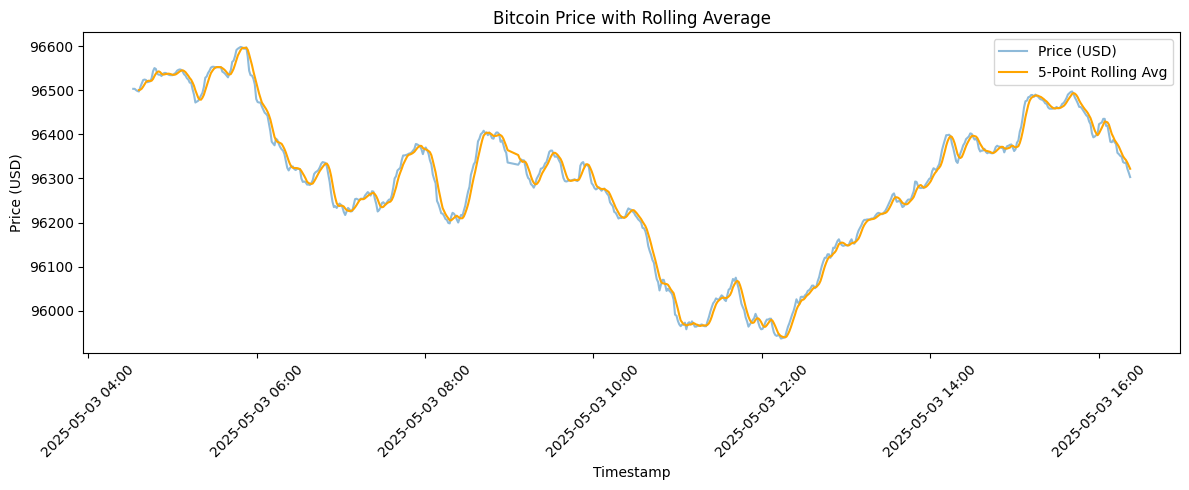

In [3]:
# Computing 5-point rolling average
df['rolling_avg_5'] = df['price_usd'].rolling(window=5).mean()

# Plotting original vs rolling average
plt.figure(figsize=(12, 5))
plt.plot(df['timestamp'], df['price_usd'], label='Price (USD)', alpha=0.5)
plt.plot(df['timestamp'], df['rolling_avg_5'], label='5-Point Rolling Avg', color='orange')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.title("Bitcoin Price with Rolling Average")
plt.xlabel("Timestamp")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

###  Rate of Change (Percentage)

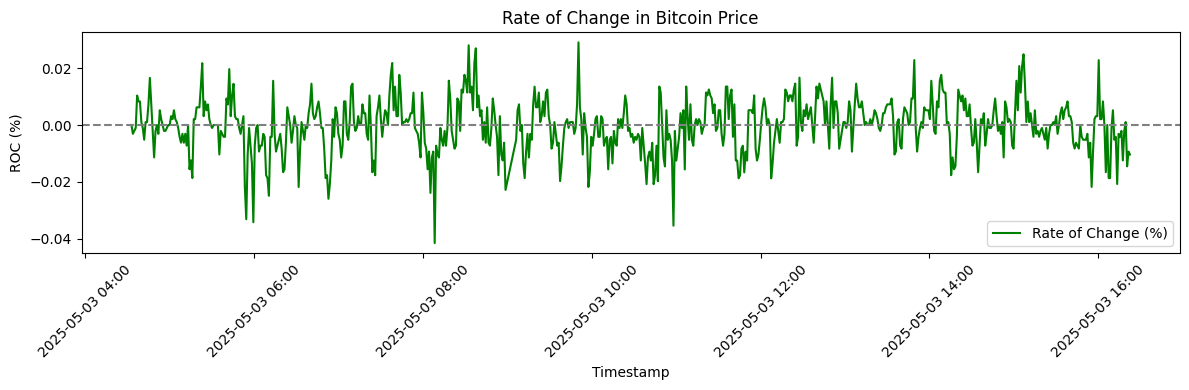

In [4]:
# Calculating rate of change
df['prev_price'] = df['price_usd'].shift(1)
df['roc_pct'] = ((df['price_usd'] - df['prev_price']) / df['prev_price']) * 100

# Plotting rate of change
plt.figure(figsize=(12, 4))
plt.plot(df['timestamp'], df['roc_pct'], label='Rate of Change (%)', color='green')
plt.axhline(0, linestyle='--', color='gray')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.title("Rate of Change in Bitcoin Price")
plt.xlabel("Timestamp")
plt.ylabel("ROC (%)")
plt.legend()
plt.tight_layout()
plt.show()

### Z-Score Based Anomaly Detection

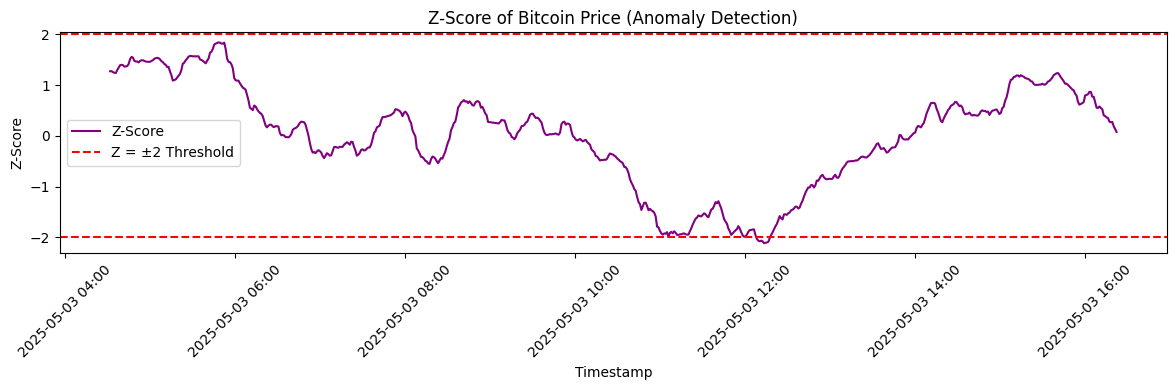

In [5]:
# Calculating Z-scores
mean = df['price_usd'].mean()
std = df['price_usd'].std()
df['z_score'] = (df['price_usd'] - mean) / std

# Plotting Z-score with anomaly threshold lines
plt.figure(figsize=(12, 4))
plt.plot(df['timestamp'], df['z_score'], label='Z-Score', color='purple')
plt.axhline(2, color='red', linestyle='--', label='Z = ±2 Threshold')
plt.axhline(-2, color='red', linestyle='--')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.title("Z-Score of Bitcoin Price (Anomaly Detection)")
plt.xlabel("Timestamp")
plt.ylabel("Z-Score")
plt.legend()
plt.tight_layout()
plt.show()

### Moving Average Convergence Divergence (MACD)

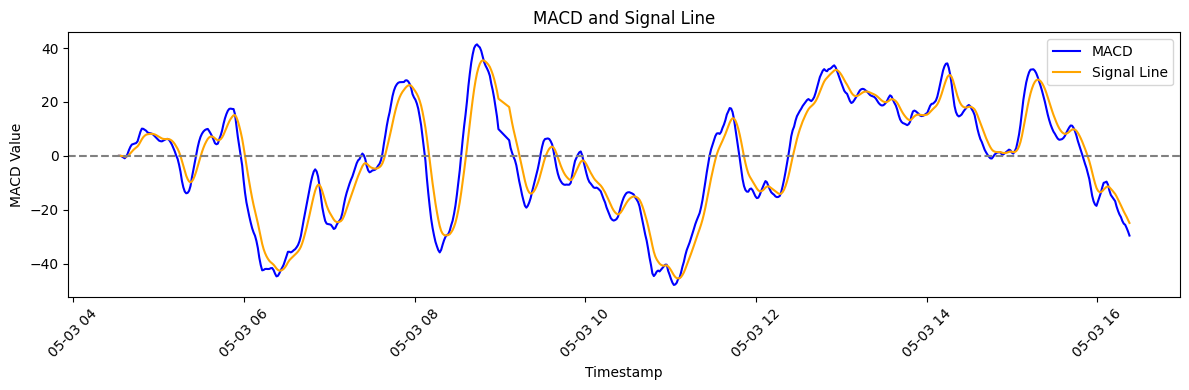

In [6]:
# MACD is the difference between two exponential moving averages (EMA)

df['ema_12'] = df['price_usd'].ewm(span=12, adjust=False).mean()
df['ema_26'] = df['price_usd'].ewm(span=26, adjust=False).mean()
df['macd'] = df['ema_12'] - df['ema_26']
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# Plotting MACD and Signal Line
plt.figure(figsize=(12, 4))
plt.plot(df['timestamp'], df['macd'], label='MACD', color='blue')
plt.plot(df['timestamp'], df['macd_signal'], label='Signal Line', color='orange')
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=45)
plt.title("MACD and Signal Line")
plt.xlabel("Timestamp")
plt.ylabel("MACD Value")
plt.legend()
plt.tight_layout()
plt.show()

### Bollinger Bands

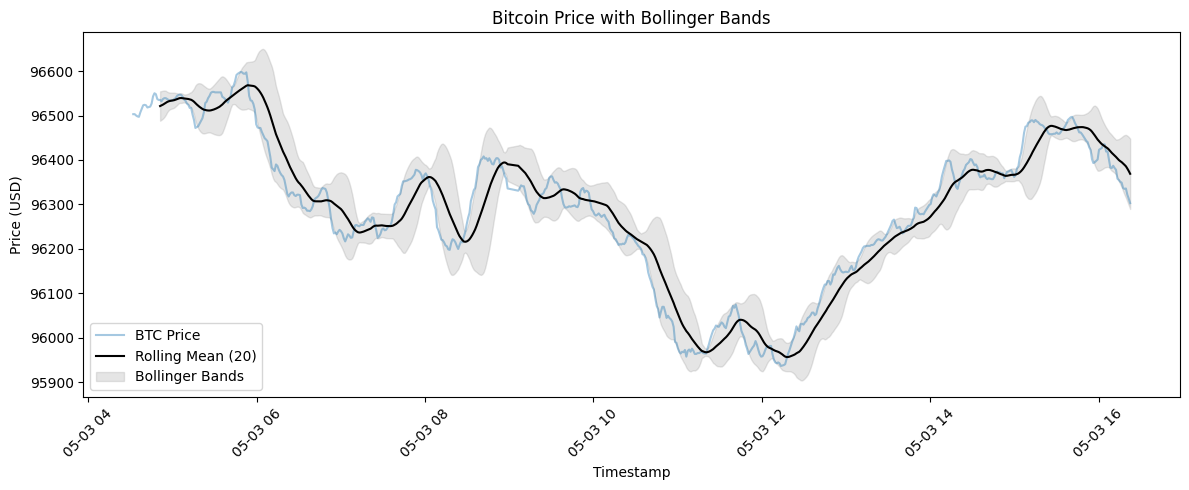

In [7]:
# Bollinger Bands use a 20-period moving average and ±2 standard deviations

df['rolling_mean_20'] = df['price_usd'].rolling(window=20).mean()
df['rolling_std_20'] = df['price_usd'].rolling(window=20).std()
df['upper_band'] = df['rolling_mean_20'] + (2 * df['rolling_std_20'])
df['lower_band'] = df['rolling_mean_20'] - (2 * df['rolling_std_20'])

# Plotting Bollinger Bands
plt.figure(figsize=(12, 5))
plt.plot(df['timestamp'], df['price_usd'], label='BTC Price', alpha=0.4)
plt.plot(df['timestamp'], df['rolling_mean_20'], label='Rolling Mean (20)', color='black')
plt.fill_between(df['timestamp'], df['lower_band'], df['upper_band'], color='gray', alpha=0.2, label='Bollinger Bands')
plt.xticks(rotation=45)
plt.title("Bitcoin Price with Bollinger Bands")
plt.xlabel("Timestamp")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()


### Isolation Forest (Anomaly Detection using ML)

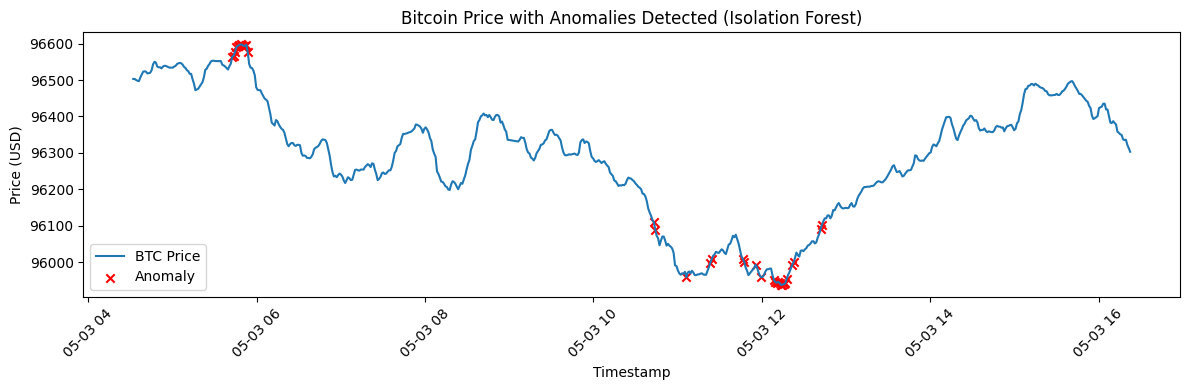

In [8]:
from sklearn.ensemble import IsolationForest

# Fitting Isolation Forest on price data
model = IsolationForest(contamination=0.05, random_state=42)
df['anomaly_iforest'] = model.fit_predict(df[['price_usd']])

# -1 indicates anomaly, 1 indicates normal
# Plotting anomalies
plt.figure(figsize=(12, 4))
plt.plot(df['timestamp'], df['price_usd'], label='BTC Price')
plt.scatter(df[df['anomaly_iforest'] == -1]['timestamp'],
            df[df['anomaly_iforest'] == -1]['price_usd'],
            color='red', label='Anomaly', marker='x')
plt.xticks(rotation=45)
plt.title("Bitcoin Price with Anomalies Detected (Isolation Forest)")
plt.xlabel("Timestamp")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

# Final Conclusion 

This time series analysis combined both simple and advanced techniques to understand Bitcoin price behavior.

- Rolling averages and rate of change revealed short-term trends and volatility.
- Z-scores and Bollinger Bands helped identify potential anomalies.
- MACD and Isolation Forest added deeper trend detection and machine learning–based anomaly spotting.

Together, these methods provide a solid foundation for monitoring, analyzing, and reacting to real-time financial data.
